# Use map iterator

The `map_` instruction in WorkGraph is conceptually similar to Python's built-in map function. In WorkGraph, the `map_` instruction spawns the tasks in the WorkGraph for each item in a dataset.

### Why use `map_`?

- **Creates dynamic tasks**: The number of tasks is determined at runtime based on input size.
- **Encapsulates child tasks**: All tasks inside a `map_` block are executed independently for each input item.

## Example: Running Tasks in Parallel with `map_`

Let's consider a simple workflow where we:
1. Generate a dictionary of numbers.
2. Add 1 to each number.
3. Multiply the result by 2.


In [1]:
from aiida_workgraph import task, WorkGraph, map_
from aiida import load_profile, orm

load_profile()

@task.calcfunction(outputs=["result"])
def generate_data(n: int) -> dict:
    """Generate a dictionary of integers."""
    result = {f"key_{i}": orm.Int(i) for i in range(n.value)}
    return {"result": result}

@task.calcfunction()
def add(x, y):
    return x + y

@task.calcfunction()
def multiply(x, y):
    return x * y

n = 3
wg = WorkGraph("parallel_addition")
wg.add_task(generate_data, name="generate_data", n=n)
# Apply `map_` to distribute the workload
map_(wg.tasks.generate_data.outputs.result)(
    wg.add_task(add, name="add1", x=map_.default_placeholder, y=1),
    wg.add_task(multiply, name="multiply2", x=wg.tasks.add1.outputs.result, y=2),
)

# Show the WorkGraph
wg.to_html()
# wg


### 🔹 What happens here?
- `map_` **automatically applies** the tasks (`add1` and `multiply2`) to **each element** in the dictionary output of `generate_data`.
- Each instance of `add1` and `multiply2` **runs independently and in parallel**.
- The `default_placeholder` is a special reference that **ensures each element is mapped correctly**.


### Running and Checking Results


In [2]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))

03/08/2025 05:12:42 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:42 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data
03/08/2025 05:12:42 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: generate_data, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'n': <Int: uuid: 7e773793-8459-4196-a155-fa409b630b4b (pk: 41978) value: 3>}


03/08/2025 05:12:43 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: generate_data finished.
03/08/2025 05:12:44 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:44 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_1
03/08/2025 05:12:44 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: map_1, type: MAP


------------------------------------------------------------
kwargs:  {'placeholder': 'map_input', 'source': AttributeDict({'key_0': <Int: uuid: 5497d787-5a2f-466b-9a38-334efc961365 (pk: 41981) value: 0>, 'key_1': <Int: uuid: 26a1bf6a-7e78-4cc7-b6a8-c26829df97c5 (pk: 41982) value: 1>, 'key_2': <Int: uuid: 2d824581-76cd-46db-b9ca-f1f01cff45ea (pk: 41983) value: 2>})}


03/08/2025 05:12:44 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:44 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add1,key_1_add1,key_2_add1
03/08/2025 05:12:44 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: key_0_add1, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 5497d787-5a2f-466b-9a38-334efc961365 (pk: 41981) value: 0>, 'y': 1}


03/08/2025 05:12:46 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: key_0_add1 finished.
03/08/2025 05:12:46 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:46 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_multiply2,key_1_add1,key_2_add1
03/08/2025 05:12:46 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: key_0_multiply2, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 6d55ca9b-aa99-4cca-9579-b2e9c4a7fc08 (pk: 41986) value: 1>}


03/08/2025 05:12:47 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: key_0_multiply2 finished.
03/08/2025 05:12:47 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:47 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_add1,key_2_add1
03/08/2025 05:12:48 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: key_1_add1, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 26a1bf6a-7e78-4cc7-b6a8-c26829df97c5 (pk: 41982) value: 1>, 'y': 1}


03/08/2025 05:12:49 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: key_1_add1 finished.
03/08/2025 05:12:49 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:49 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_multiply2,key_2_add1
03/08/2025 05:12:49 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: key_1_multiply2, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 7348b877-bc1b-4d64-a82f-c16b61bee18a (pk: 41992) value: 2>}


03/08/2025 05:12:50 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: key_1_multiply2 finished.
03/08/2025 05:12:50 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:50 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_add1
03/08/2025 05:12:50 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: key_2_add1, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 2d824581-76cd-46db-b9ca-f1f01cff45ea (pk: 41983) value: 2>, 'y': 1}


03/08/2025 05:12:52 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: key_2_add1 finished.
03/08/2025 05:12:52 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_template_task_state]: Task: add1 finished.
03/08/2025 05:12:52 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:52 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_multiply2
03/08/2025 05:12:52 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|run_tasks]: Run task: key_2_multiply2, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 978cc6d8-0813-4cd4-804d-1178136c545b (pk: 41998) value: 3>}


03/08/2025 05:12:53 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_task_state]: Task: key_2_multiply2 finished.
03/08/2025 05:12:54 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_template_task_state]: Task: multiply2 finished.
03/08/2025 05:12:54 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|update_zone_task_state]: Task: map_1 finished.
03/08/2025 05:12:54 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:54 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/08/2025 05:12:54 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [41979|WorkGraphEngine|finalize]: Finalize workgraph.


State of WorkGraph:   FINISHED


Generate node graph from the AiiDA process:

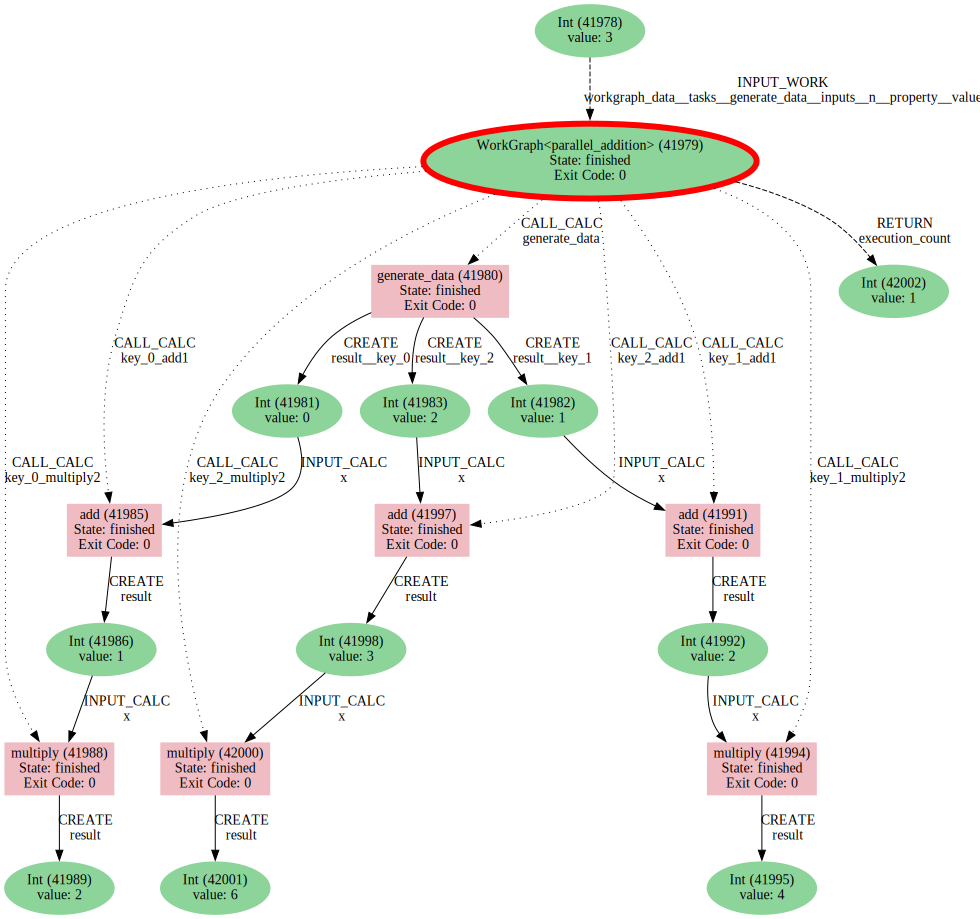

In [3]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_parallel` tasks and calculate the sum of all their results.
Let's update the `multiply_parallel` function to `multiply_parallel_gather`.

In [4]:
@task.calcfunction()
def calc_sum(**datas) -> dict:
    """Compute the sum of all provided values."""
    return  sum(datas.values())

n = 3
wg = WorkGraph("parallel_addition")
wg.add_task(generate_data, name="generate_data", n=n)
# Apply `map_` to distribute the workload
map_(wg.tasks.generate_data.outputs.result)(
    wg.add_task(add, name="add", x=map_.default_placeholder, y=1),
    wg.add_task(multiply, name="multiply", x=wg.tasks.add.outputs.result, y=2),
)
wg.add_task(calc_sum, name="calc_sum", datas=wg.tasks.multiply.outputs.result)
wg.to_html()

Run the workgraph and get the result of the tasks:

In [5]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))
print('Result of task add1: {}'.format(wg.tasks.calc_sum.outputs.result))

03/08/2025 05:12:59 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:12:59 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data
03/08/2025 05:12:59 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: generate_data, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'n': <Int: uuid: 94390853-ba6e-4707-a3db-2ecb86903cdc (pk: 42003) value: 3>}


03/08/2025 05:13:00 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: generate_data finished.
03/08/2025 05:13:00 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:00 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_1
03/08/2025 05:13:00 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: map_1, type: MAP


------------------------------------------------------------
kwargs:  {'placeholder': 'map_input', 'source': AttributeDict({'key_0': <Int: uuid: 1fe6d3ee-80d8-4717-9eb7-4802709c080f (pk: 42006) value: 0>, 'key_1': <Int: uuid: e2b95d08-a8a2-42bc-ac17-b1789622399f (pk: 42007) value: 1>, 'key_2': <Int: uuid: a02fece0-22ae-4f0b-9ba2-1af6369d47eb (pk: 42008) value: 2>})}


03/08/2025 05:13:01 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:01 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add,key_1_add,key_2_add
03/08/2025 05:13:01 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: key_0_add, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 1fe6d3ee-80d8-4717-9eb7-4802709c080f (pk: 42006) value: 0>, 'y': 1}


03/08/2025 05:13:02 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: key_0_add finished.
03/08/2025 05:13:02 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:02 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_multiply,key_1_add,key_2_add
03/08/2025 05:13:02 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: key_0_multiply, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 087642c3-a56f-4e3a-af07-34548b3a3538 (pk: 42011) value: 1>}


03/08/2025 05:13:03 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: key_0_multiply finished.
03/08/2025 05:13:03 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:03 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_add,key_2_add
03/08/2025 05:13:03 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: key_1_add, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: e2b95d08-a8a2-42bc-ac17-b1789622399f (pk: 42007) value: 1>, 'y': 1}


03/08/2025 05:13:05 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: key_1_add finished.
03/08/2025 05:13:05 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:05 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_multiply,key_2_add
03/08/2025 05:13:05 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: key_1_multiply, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 54d22d2a-396e-409e-ba30-154b51851058 (pk: 42017) value: 2>}


03/08/2025 05:13:06 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: key_1_multiply finished.
03/08/2025 05:13:06 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:06 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_add
03/08/2025 05:13:06 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: key_2_add, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: a02fece0-22ae-4f0b-9ba2-1af6369d47eb (pk: 42008) value: 2>, 'y': 1}


03/08/2025 05:13:07 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: key_2_add finished.
03/08/2025 05:13:07 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_template_task_state]: Task: add finished.
03/08/2025 05:13:07 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:08 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_multiply
03/08/2025 05:13:08 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: key_2_multiply, type: CALCFUNCTION


------------------------------------------------------------
kwargs:  {'y': 2, 'x': <Int: uuid: 6f00a0b7-2fb7-4430-a0a6-3dd90241a970 (pk: 42023) value: 3>}


03/08/2025 05:13:09 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: key_2_multiply finished.
03/08/2025 05:13:09 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_template_task_state]: Task: multiply finished.
03/08/2025 05:13:09 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_zone_task_state]: Task: map_1 finished.
03/08/2025 05:13:09 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:09 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: calc_sum
03/08/2025 05:13:09 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|run_tasks]: Run task: cal

------------------------------------------------------------
kwargs:  {}


03/08/2025 05:13:10 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|update_task_state]: Task: calc_sum finished.
03/08/2025 05:13:10 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/08/2025 05:13:11 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/08/2025 05:13:11 PM <302702> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [42004|WorkGraphEngine|finalize]: Finalize workgraph.


State of WorkGraph:   FINISHED
Result of task add1: SocketAny(name='result', value=uuid: 574480dd-9409-463c-a61d-9d668b620d4c (pk: 42028) value: 12)


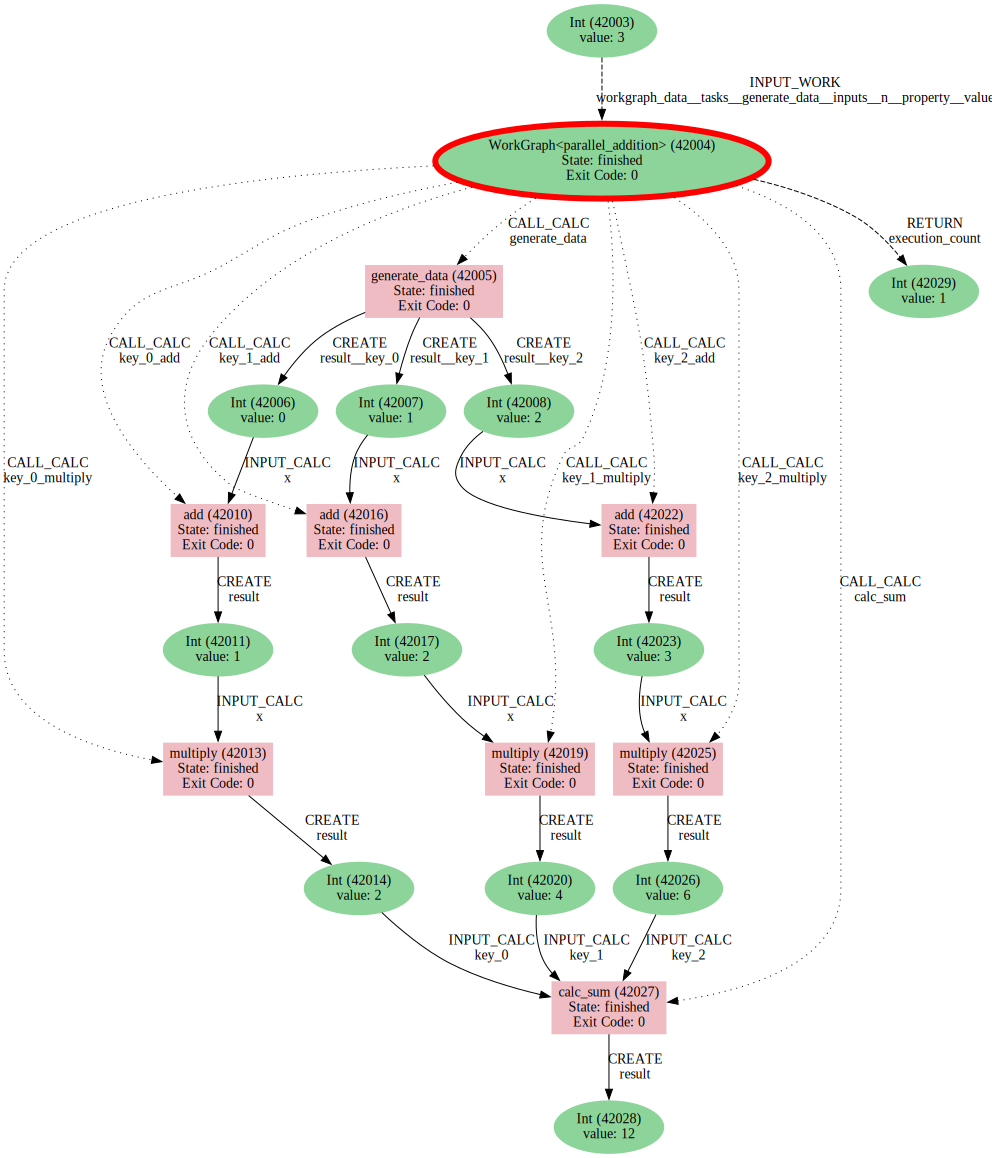

In [6]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

You can see that the outputs of `multiply_parallel_gather` workgraph is linked to the input of the `sum` task.